In [2]:
# %load week10.py

import nltk

In [5]:
#文法
grammar = nltk.CFG.fromstring("""
S -> NP VP
VP -> V AP | V NP
V -> '是'|'走在'|'进入'
AP -> '很抽象的'
NP -> '北京'|'哈尔滨'|'形式语言'|'中国'|'教育'|'集合'|'WTO'|'美丽的城市'|'祖国的首都'|'数学的基础'|'社会发展的前面'
""")  

In [7]:
sent = ['集合','是','数学的基础']
parser = nltk.ChartParser(grammar)
trees=parser.parse(sent)
for tree in trees:
    print(tree)
#     tree.draw()

(S (NP 集合) (VP (V 是) (NP 数学的基础)))


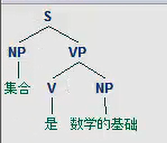

In [8]:
#普遍存在的歧义
groucho_grammar = nltk.CFG.fromstring("""
S -> NP VP
NP -> Det NP | Det AP N | AP N  | N
VP -> V AP | V NP
N -> '校长'|'座谈会'
Det -> '三个'
AP -> '学校的'
V -> '参加'
""")    
    
sent = ['三个', '学校的', '校长', '参加', '座谈会']
parser = nltk.ChartParser(groucho_grammar)
trees = parser.parse(sent)
for tree in trees:
    print(tree)
#     tree.draw() 

(S (NP (Det 三个) (AP 学校的) (N 校长)) (VP (V 参加) (NP (N 座谈会))))
(S (NP (Det 三个) (NP (AP 学校的) (N 校长))) (VP (V 参加) (NP (N 座谈会))))


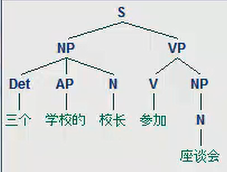

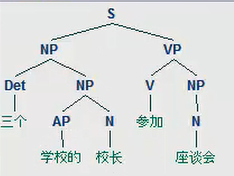

In [9]:
#上下文无关文法
grammar1 = nltk.CFG.fromstring("""
S -> NP VP
VP -> V NP | V NP PP
PP -> P NP
V -> "saw" | "ate" | "walked"
NP -> "John" | "Mary" | "Bob" | Det N | Det N PP
Det -> "a" | "an" | "the" | "my"
N -> "man" | "dog" | "cat" | "telescope" | "park"
P -> "in" | "on" | "by" | "with"
""")
sent = "Mary saw Bob".split()
rd_parser = nltk.RecursiveDescentParser(grammar1)
for tree in rd_parser.parse(sent):
    print (tree)

(S (NP Mary) (VP (V saw) (NP Bob)))


In [10]:
sent="the dog saw a man in the park".split()
rd_parser = nltk.RecursiveDescentParser(grammar1)
for tree in rd_parser.parse(sent):
    print (tree)
#     tree.draw()  

(S
  (NP (Det the) (N dog))
  (VP
    (V saw)
    (NP (Det a) (N man) (PP (P in) (NP (Det the) (N park))))))
(S
  (NP (Det the) (N dog))
  (VP
    (V saw)
    (NP (Det a) (N man))
    (PP (P in) (NP (Det the) (N park)))))


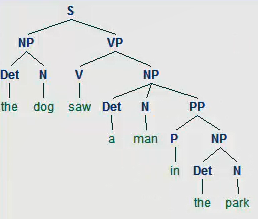

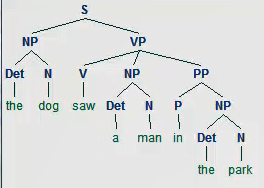

In [11]:
#递归的上下文无关文法
grammar2 = nltk.CFG.fromstring("""
S -> NP VP
NP -> Det Nom | PropN
Nom -> Adj Nom | N
VP -> V Adj | V NP | V S | V NP PP
PP -> P NP
PropN -> 'Buster' | 'Chatterer' | 'Joe'
Det -> 'the' | 'a'
N -> 'bear' | 'squirrel' | 'tree' | 'fish' | 'log'
Adj -> 'angry' | 'frightened' | 'little' | 'tall'
V -> 'chased' | 'saw' | 'said' | 'thought' | 'was' | 'put'
P -> 'on'
""")
sent="the angry bear chased the frightened little squirrel".split()
rd_parser = nltk.RecursiveDescentParser(grammar2)
for tree in rd_parser.parse(sent):
    print (tree)
#     tree.draw()  

(S
  (NP (Det the) (Nom (Adj angry) (Nom (N bear))))
  (VP
    (V chased)
    (NP
      (Det the)
      (Nom (Adj frightened) (Nom (Adj little) (Nom (N squirrel)))))))


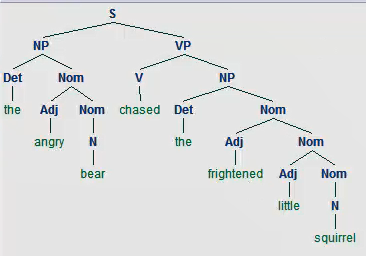

In [12]:
#递归下降解析器
rd_parser = nltk.RecursiveDescentParser(grammar2)
sent = 'Joe saw a bear'.split()
for t in rd_parser.parse(sent):
    print (t)    

(S (NP (PropN Joe)) (VP (V saw) (NP (Det a) (Nom (N bear)))))


#### 递归下降解析器的缺点
再处理NP -> NP PP的语法时会陷入死循环；  
处理不符合语法的句子时会浪费很多时间

In [13]:
#移进-归约解析器
sr_parse = nltk.ShiftReduceParser(grammar2,trace=2)
sent = 'Joe saw a bear'.split()
for t in sr_parse.parse(sent):
    print (t) 

Parsing 'Joe saw a bear'
    [ * Joe saw a bear]
  S [ 'Joe' * saw a bear]
  R [ PropN * saw a bear]
  R [ NP * saw a bear]
  S [ NP 'saw' * a bear]
  R [ NP V * a bear]
  S [ NP V 'a' * bear]
  R [ NP V Det * bear]
  S [ NP V Det 'bear' * ]
  R [ NP V Det N * ]
  R [ NP V Det Nom * ]
  R [ NP V NP * ]
  R [ NP VP * ]
  R [ S * ]
(S (NP (PropN Joe)) (VP (V saw) (NP (Det a) (Nom (N bear)))))


In [16]:
#图表分析
groucho_grammar = nltk.CFG.fromstring("""
S -> NP VP
PP -> P NP
NP -> Det N | Det N PP | 'I'
VP -> V NP | VP PP
Det -> 'an' | 'my'
N -> 'elephant' | 'pajamas'
V -> 'shot'
P -> 'in'
""")

text = ['I', 'shot', 'an', 'elephant', 'in', 'my', 'pajamas']  
 
def init_wfst(tokens, grammar):
    numtokens = len(tokens)
    wfst = [[None for i in range(numtokens+1)] for j in range(numtokens+1)]
    for i in range(numtokens):
        productions = grammar.productions(rhs=tokens[i])
        wfst[i][i+1] = productions[0].lhs()
    return wfst
    
def complete_wfst(wfst, tokens, grammar, trace=False):
    index = dict((p.rhs(), p.lhs()) for p in grammar.productions())
    numtokens = len(tokens)
    for span in range(2, numtokens+1):
        for start in range(numtokens+1-span):
            end = start + span
            for mid in range(start+1, end):
                nt1, nt2 = wfst[start][mid], wfst[mid][end]
                if nt1 and nt2 and (nt1,nt2) in index:
                    wfst[start][end] = index[(nt1,nt2)]
                    if trace:
                        print ("[%s] %3s [%s] %3s [%s] ==> [%s] %3s [%s]" %(start, nt1, mid, nt2, end, start, index[(nt1,nt2)], end))
    return wfst
    
def display(wfst, tokens):
    print ('\nWFST ' + ' '.join([("%-4d" % i) for i in range(1, len(wfst))]))
    for i in range(len(wfst)-1): 
        print ("%d " % i,)
        for j in range(1, len(wfst)):
            print ("%-4s" % (wfst[i][j] or '.'),)
        print()

In [17]:
tokens = "I shot an elephant in my pajamas".split()
wfst0 = init_wfst(tokens, groucho_grammar)
display(wfst0, tokens)  


WFST 1    2    3    4    5    6    7   
0 
NP  
.   
.   
.   
.   
.   
.   

1 
.   
V   
.   
.   
.   
.   
.   

2 
.   
.   
Det 
.   
.   
.   
.   

3 
.   
.   
.   
N   
.   
.   
.   

4 
.   
.   
.   
.   
P   
.   
.   

5 
.   
.   
.   
.   
.   
Det 
.   

6 
.   
.   
.   
.   
.   
.   
N   



In [18]:
wfst1 = complete_wfst(wfst0, tokens, groucho_grammar)
display(wfst1, tokens)    


WFST 1    2    3    4    5    6    7   
0 
NP  
.   
.   
S   
.   
.   
S   

1 
.   
V   
.   
VP  
.   
.   
VP  

2 
.   
.   
Det 
NP  
.   
.   
.   

3 
.   
.   
.   
N   
.   
.   
.   

4 
.   
.   
.   
.   
P   
.   
PP  

5 
.   
.   
.   
.   
.   
Det 
NP  

6 
.   
.   
.   
.   
.   
.   
N   



In [19]:
wfst1 = complete_wfst(wfst0, tokens, groucho_grammar, trace=True)

[2] Det [3]   N [4] ==> [2]  NP [4]
[5] Det [6]   N [7] ==> [5]  NP [7]
[1]   V [2]  NP [4] ==> [1]  VP [4]
[4]   P [5]  NP [7] ==> [4]  PP [7]
[0]  NP [1]  VP [4] ==> [0]   S [4]
[1]  VP [4]  PP [7] ==> [1]  VP [7]
[0]  NP [1]  VP [7] ==> [0]   S [7]


In [20]:
#依存关系
groucho_dep_grammar = nltk.DependencyGrammar.fromstring("""
'shot' -> 'I' | 'elephant' | 'in'
'elephant' -> 'an' | 'in'
'in' -> 'pajamas'
'pajamas' -> 'my'
""")
print (groucho_dep_grammar)

Dependency grammar with 7 productions
  'shot' -> 'I'
  'shot' -> 'elephant'
  'shot' -> 'in'
  'elephant' -> 'an'
  'elephant' -> 'in'
  'in' -> 'pajamas'
  'pajamas' -> 'my'


In [21]:
pdp = nltk.ProjectiveDependencyParser(groucho_dep_grammar)
sent = 'I shot an elephant in my pajamas'.split()
trees = pdp.parse(sent)
for tree in trees:
    print(tree)

(shot I (elephant an (in (pajamas my))))
(shot I (elephant an) (in (pajamas my)))


In [22]:
#文法开发
from nltk.corpus import treebank
t = treebank.parsed_sents('wsj_0001.mrg')[0]
print (t)  

(S
  (NP-SBJ
    (NP (NNP Pierre) (NNP Vinken))
    (, ,)
    (ADJP (NP (CD 61) (NNS years)) (JJ old))
    (, ,))
  (VP
    (MD will)
    (VP
      (VB join)
      (NP (DT the) (NN board))
      (PP-CLR (IN as) (NP (DT a) (JJ nonexecutive) (NN director)))
      (NP-TMP (NNP Nov.) (CD 29))))
  (. .))


In [ ]:







    



def filter(tree):
    child_nodes = [child.label() for child in tree
                   if isinstance(child, nltk.Tree)]
    return  (tree.label() == 'VP') and ('S' in child_nodes)
    
from nltk.corpus import treebank  
[subtree for tree in treebank.parsed_sents()
         for subtree in tree.subtrees(filter)]
             
from collections import defaultdict
entries = nltk.corpus.ppattach.attachments('training')
table = defaultdict(lambda: defaultdict(set))
for entry in entries:
    key = entry.noun1 + '-' + entry.prep + '-' + entry.noun2
    table[key][entry.attachment].add(entry.verb)

for key in sorted(table):
    if len(table[key]) > 1:
        print(key, 'N:', sorted(table[key]['N']), 'V:', sorted(table[key]['V']))   

nltk.corpus.sinica_treebank.parsed_sents()[3450].draw()


 	
grammar = nltk.CFG.fromstring("""
S -> NP V NP
NP -> NP Sbar
Sbar -> NP V
NP -> 'fish'
V -> 'fish'
""")

tokens = ["fish"] * 5
cp = nltk.ChartParser(grammar)
for tree in cp.parse(tokens):
    print(tree)

tokens = ["fish"] * 7
cp = nltk.ChartParser(grammar)
for tree in cp.parse(tokens):
    print(tree)
    
tokens = ["fish"] * 9
cp = nltk.ChartParser(grammar)
for tree in cp.parse(tokens):
    print(tree)    
    
#加权文法
def give(t):
    return t.label() == 'VP' and len(t) > 2 and t[1].label() == 'NP'\
           and (t[2].label() == 'PP-DTV' or t[2].label() == 'NP')\
           and ('give' in t[0].leaves() or 'gave' in t[0].leaves())
           
def sent(t):
    return ' '.join(token for token in t.leaves() if token[0] not in '*-0')
    
def print_node(t, width):
        output = "%s %s: %s / %s: %s" %\
            (sent(t[0]), t[1].label(), sent(t[1]), t[2].label(), sent(t[2]))
        if len(output) > width:
            output = output[:width] + "..."
        print(output)    
        
for tree in nltk.corpus.treebank.parsed_sents():
    for t in tree.subtrees(give):
        print_node(t, 72)    


#概率上下文无关文法
grammar = nltk.PCFG.fromstring("""
    S    -> NP VP              [1.0]
    VP   -> TV NP              [0.4] 
    VP   -> IV                 [0.3]
    VP   -> DatV NP NP         [0.3]
    TV   -> 'saw'              [1.0]
    IV   -> 'ate'              [1.0]
    DatV -> 'gave'             [1.0]
    NP   -> 'telescopes'       [0.8]
    NP   -> 'Jack'             [0.2]
    """)
print(grammar)      

viterbi_parser = nltk.ViterbiParser(grammar)
for tree in viterbi_parser.parse(['Jack', 'saw', 'telescopes']):
    print(tree) 